In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Cell 1: mount drive & basics ===
from google.colab import drive
drive.mount('/content/drive')

DRIVE_BASE = "/content/drive/MyDrive/Crack Study"   # change if needed

# GPU check
!nvidia-smi
import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri Dec  5 14:12:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|          

In [ ]:
# === Cell 2: install libs ===
!pip install -q imgaug==0.4.0 tensorflow-addons tf2onnx onnx onnxruntime scikit-image fpdf

# Standard imports
import os, glob, re, math, random
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.measure import label, regionprops

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
import os

for root, dirs, files in os.walk('/content/drive/MyDrive/Crack Study', topdown=True):
    print(root)
    for d in dirs:
        print("  DIR →", d)
    for f in files:
        print("  FILE →", f)
    print("──")

In [ ]:
# Cell 1 - confirm mount and set up variables
import os
print("Drive mount exists?", os.path.exists('/content/drive'))
print("Listing /content/drive (top-level):", os.listdir('/content/drive')[:40] if os.path.exists('/content/drive') else "No drive")

# your shared folder id (from the link)
FOLDER_ID = "1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5"
OUT_ROOT = "/content/crack_study_download"   # where we'll download the folder contents
os.makedirs(OUT_ROOT, exist_ok=True)
print("Will download shared folder id:", FOLDER_ID, "→", OUT_ROOT)

Drive mount exists? True
Listing /content/drive (top-level): ['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']
Will download shared folder id: 1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5 → /content/crack_study_download


In [ ]:
# Cell 2 - authenticate and build Drive API client
from google.colab import auth
auth.authenticate_user()

import google.auth
from googleapiclient.discovery import build
creds, _ = google.auth.default()
drive_service = build('drive', 'v3', credentials=creds)
print("Drive service ready")

Drive service ready


In [ ]:
# Cell 3 - helpers to list & download folder recursively
import io, pathlib, os
from googleapiclient.http import MediaIoBaseDownload

def list_folder(folder_id):
    """Return list of files/folders under a Google folder ID."""
    q = f"'{folder_id}' in parents and trashed=false"
    items = []
    page_token = None
    while True:
        resp = drive_service.files().list(
            q=q,
            fields="nextPageToken, files(id, name, mimeType)",
            pageToken=page_token
        ).execute()
        items.extend(resp.get('files', []))
        page_token = resp.get('nextPageToken')
        if not page_token:
            break
    return items

def download_file(file_id, dest_path):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(dest_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
    fh.close()

def download_folder_recursive(folder_id, local_path):
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)
    items = list_folder(folder_id)
    if not items:
        print("Folder is empty or inaccessible:", folder_id)
    for it in items:
        name = it['name']
        fid = it['id']
        mime = it['mimeType']
        safe_name = name.replace('/', '_')

        if mime == 'application/vnd.google-apps.folder':
            print("Creating folder:", safe_name)
            download_folder_recursive(fid, os.path.join(local_path, safe_name))
        else:
            dest = os.path.join(local_path, safe_name)
            print("Downloading file:", name, "→", dest)
            try:
                download_file(fid, dest)
            except Exception as e:
                print("Failed to download", name, ":", str(e))

In [ ]:
# Cell 4 - list contents of the shared folder
items = list_folder(FOLDER_ID)
print("Top-level items inside the shared folder:")
for it in items:
    print("-", it['name'], "(", it['mimeType'], ")", "id:", it['id'])

Top-level items inside the shared folder:
- Concrete S3 90days.png ( image/png ) id: 1oYDYG7Ra8hwIWN7KHUBTGYdvlxUvPHAt
- Concrete S2 90days.png ( image/png ) id: 1e5MPoGlehqyLkbrDsdUG8rvUPvhBGCzd
- Concrete S1 90days.png ( image/png ) id: 1CSU5TKG3prsdK6lpUWNlLBbB-PZIuNxF
- Concrete S3 56days.png ( image/png ) id: 1AFXXEFZe5ac_onaI0T1oEUbHLf7y1d0O
- Concrete S2 56days.png ( image/png ) id: 1kcSpECwHfTUTMD7JTm3gtgwhD7lV0BM0
- Concrete S1 56days.png ( image/png ) id: 1syvWrmW7YMqq2wy7hTKNc6oYIzWx3xjJ
- 3 S2 mortar 56days.png ( image/png ) id: 1KpKjEGFcIlGhkLYORET8l-THDgdT6URW
- 3 S1 mortar 56days.png ( image/png ) id: 1ix7q8BELyQpSo30Bz0hdPq4_kJlRPT2I
- Concrete S1 28days.png ( image/png ) id: 1QxHCU-Hqw9DbJBwZe3LEfWq3mQ_oSzzZ
- 2 S3 cube 28days.png ( image/png ) id: 1UWcRimWb-hAoVggMkK4vGM-N3aSskzCn
- 2 S2 cube 28days.png ( image/png ) id: 1l7PCXDmlTSy4xuwoeUyOlEizoIkDh3TK
- 2 S1 cube 28days.png ( image/png ) id: 11axEAsYJ7unmiHkXT7YzF_bvBr0EJ1w8
- S2 mortar 28days.png ( image/png ) id:

In [ ]:
# Cell 0 - quick vars (run first)
FOLDER_ID = "1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5"
OUT_ROOT = "/content/crack_study_download"
DRIVE_COPY_ROOT = OUT_ROOT   # local copy we'll use
print("Shared folder id:", FOLDER_ID)
print("Local download target:", OUT_ROOT)

Shared folder id: 1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5
Local download target: /content/crack_study_download


In [ ]:
# Cell 1 - auth + drive client
from google.colab import auth
auth.authenticate_user()

import google.auth
from googleapiclient.discovery import build
creds, _ = google.auth.default()
drive_service = build('drive', 'v3', credentials=creds)
print("Drive API ready")

Drive API ready


In [ ]:
# Cell 2 - download helpers & perform download
import io, os, pathlib
from googleapiclient.http import MediaIoBaseDownload

def list_folder(folder_id):
    q = f"'{folder_id}' in parents and trashed=false"
    items = []
    page_token = None
    while True:
        resp = drive_service.files().list(q=q, spaces='drive',
                                         fields="nextPageToken, files(id, name, mimeType)",
                                         pageToken=page_token).execute()
        items.extend(resp.get('files', []))
        page_token = resp.get('nextPageToken')
        if not page_token:
            break
    return items

def download_file(file_id, dest_path):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(dest_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
    fh.close()

def download_folder_recursive(folder_id, local_path):
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)
    items = list_folder(folder_id)
    if not items:
        print("Folder empty or inaccessible:", folder_id)
    for it in items:
        name = it['name']
        fid = it['id']
        mime = it['mimeType']
        safe_name = name.replace('/', '_')
        if mime == 'application/vnd.google-apps.folder':
            print("Creating folder:", safe_name)
            download_folder_recursive(fid, os.path.join(local_path, safe_name))
        else:
            dest = os.path.join(local_path, safe_name)
            print("Downloading file:", name, "→", dest)
            try:
                download_file(fid, dest)
            except Exception as e:
                print("Failed to download", name, ":", str(e))

# Run download (this will copy the shared folder to /content/crack_study_download)
download_folder_recursive(FOLDER_ID, OUT_ROOT)
print("Download finished. Local root:", OUT_ROOT)

# quick list
for root, dirs, files in os.walk(OUT_ROOT):
    print(root)
    print("  dirs:", dirs[:10])
    print("  files:", files[:20])
    break

Download finished. Local root: /content/crack_study_download
/content/crack_study_download
  dirs: []
  files: ['S2 mortar 28days.png', '2 S1 cube 28days.png', 'S1.5 mortar 28days.png', 'S3 cube 7days.png', '1 S2 mortar 7days.png', 'S1 cube 7days.png', 'Concrete S1 56days.png', '3 S2 mortar 56days.png', 'S2 cube 7days.png', 'Concrete S2 90days.png', '2 S3 mortar 28days.png', '2 S2.5 mortar 28days.png', 'Concrete S2 56days.png', '2 S3 cube 28days.png', '3 S1 mortar 56days.png', '2 S0.5 mortar 28days.png', 'Concrete S3 90days.png', 'Concrete S1 90days.png', '2 S2 cube 28days.png', 'Concrete S1 28days.png']


In [ ]:
# Cell 3 - install necessary packages (compatible with TF 2.19)
!pip install -q tf2onnx onnx onnxruntime scikit-image fpdf imgaug==0.4.0

# standard imports
import os, glob, re, math, random, json
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.measure import label, regionprops

print("TF version:", tf.__version__)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatibl

In [ ]:
# Cell 4 - autogenerate labels CSV from downloaded files
ROOT = OUT_ROOT  # localized copy
images_dir = ROOT   # top-level contains all PNGs as per your listing
masks_dir = ROOT    # if masks are separate, adapt below (this will check same name in _masks subfolder too)

# helper to find mask: check same filename in masks/ or masks folder sibling
def find_mask_for_image(img_path):
    fname = os.path.basename(img_path)
    candidates = []
    # common locations
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", os.path.splitext(fname)[0] + ".png"))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", os.path.splitext(fname)[0] + ".png"))
    # also allow same folder (if masks stored next to images and named mask_*)
    candidates.append(os.path.join(os.path.dirname(img_path), "mask_" + fname))
    for c in candidates:
        if os.path.exists(c):
            return c
    # finally check if a file with same basename (maybe user saved mask files into same folder)
    alt = os.path.join(os.path.dirname(img_path), os.path.splitext(fname)[0] + "_mask.png")
    if os.path.exists(alt):
        return alt
    return None

# parse S value, material, age from filename
def parse_metadata_from_name(fname):
    t = fname.lower()
    s_val = None
    material = None
    age = None
    # find S tokens like s1, s1.5, s2.5, s0.5
    m_s = re.search(r'(s\d+(\.\d+)?)', t)
    if m_s:
        s_val = m_s.group(1)
    if 'mortar' in t:
        material = 'mortar'
    elif 'cube' in t:
        material = 'cube'
    elif 'concrete' in t:
        material = 'concrete'
    # age digits + days
    m_age = re.search(r'(\d{1,3})\s*days?', t)
    if m_age:
        age = int(m_age.group(1))
    else:
        m_age2 = re.search(r'(\d{1,3})days', t)
        if m_age2:
            age = int(m_age2.group(1))
    return s_val or "unknown", material or "unknown", int(age) if age is not None else -1

def mask_coverage_and_angle(mask_path):
    if mask_path is None or not os.path.exists(mask_path):
        return 0.0, None
    mask = np.array(Image.open(mask_path).convert("L"))
    bw = (mask > 0).astype(np.uint8)
    if bw.sum() == 0:
        return 0.0, None
    coverage = bw.sum() / bw.size
    lab = label(bw)
    props = regionprops(lab)
    if len(props) == 0:
        return float(coverage), None
    largest = max(props, key=lambda p: p.area)
    coords = largest.coords.astype(np.float32)
    coords_centered = coords - coords.mean(axis=0)
    cov = np.cov(coords_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = math.degrees(math.atan2(principal[0], principal[1])) % 180.0
    return float(coverage), float(angle)

# find image files (png/jpg) in downloaded folder root and subfolders
img_paths = []
for ext in ("*.png","*.jpg","*.jpeg","*.tif"):
    img_paths.extend(glob.glob(os.path.join(ROOT, "**", ext), recursive=True))
img_paths = sorted(img_paths)
print("Found image files:", len(img_paths))

rows=[]
for p in tqdm(img_paths):
    fname = os.path.basename(p)
    s_val, material, age = parse_metadata_from_name(fname)
    # try to locate mask (in same folder under masks or masks_raw or matching naming)
    mpath = find_mask_for_image(p)
    cov, angle = mask_coverage_and_angle(mpath)
    # severity thresholds
    if cov <= 0.01:
        severity = 'hairline'
    elif cov <= 0.05:
        severity = 'moderate'
    else:
        severity = 'severe'
    rows.append({
        "image_path": p,
        "mask_path": mpath or "",
        "mask_coverage": cov,
        "orientation_deg": angle if angle is not None else -1.0,
        "severity": severity,
        "material": material,
        "age_days": age,
        "S_val": s_val
    })

df = pd.DataFrame(rows)
print("Total samples:", len(df))
display(df.head())

csv_out = os.path.join(ROOT, "labels_autogen.csv")
df.to_csv(csv_out, index=False)
print("Saved labels CSV to:", csv_out)

Found image files: 22


100%|██████████| 22/22 [00:00<00:00, 10884.02it/s]

Total samples: 22


,image_path,mask_path,mask_coverage,orientation_deg,severity,material,age_days,S_val
0,/content/crack_study_download/1 S2 mortar 7day...,,0.0,-1.0,hairline,mortar,7,s2
1,/content/crack_study_download/2 S0.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s0.5
2,/content/crack_study_download/2 S1 cube 28days...,,0.0,-1.0,hairline,cube,28,s1
3,/content/crack_study_download/2 S2 cube 28days...,,0.0,-1.0,hairline,cube,28,s2
4,/content/crack_study_download/2 S2.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s2.5


Saved labels CSV to: /content/crack_study_download/labels_autogen.csv


In [ ]:
# Cell 4 - autogenerate labels CSV from downloaded files
ROOT = OUT_ROOT  # localized copy
images_dir = ROOT   # top-level contains all PNGs as per your listing
masks_dir = ROOT    # if masks are separate, adapt below (this will check same name in _masks subfolder too)

# helper to find mask: check same filename in masks/ or masks folder sibling
def find_mask_for_image(img_path):
    fname = os.path.basename(img_path)
    candidates = []
    # common locations
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", os.path.splitext(fname)[0] + ".png"))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", os.path.splitext(fname)[0] + ".png"))
    # also allow same folder (if masks stored next to images and named mask_*)
    candidates.append(os.path.join(os.path.dirname(img_path), "mask_" + fname))
    for c in candidates:
        if os.path.exists(c):
            return c
    # finally check if a file with same basename (maybe user saved mask files into same folder)
    alt = os.path.join(os.path.dirname(img_path), os.path.splitext(fname)[0] + "_mask.png")
    if os.path.exists(alt):
        return alt
    return None

# parse S value, material, age from filename
def parse_metadata_from_name(fname):
    t = fname.lower()
    s_val = None
    material = None
    age = None
    # find S tokens like s1, s1.5, s2.5, s0.5
    m_s = re.search(r'(s\d+(\.\d+)?)', t)
    if m_s:
        s_val = m_s.group(1)
    if 'mortar' in t:
        material = 'mortar'
    elif 'cube' in t:
        material = 'cube'
    elif 'concrete' in t:
        material = 'concrete'
    # age digits + days
    m_age = re.search(r'(\d{1,3})\s*days?', t)
    if m_age:
        age = int(m_age.group(1))
    else:
        m_age2 = re.search(r'(\d{1,3})days', t)
        if m_age2:
            age = int(m_age2.group(1))
    return s_val or "unknown", material or "unknown", int(age) if age is not None else -1

def mask_coverage_and_angle(mask_path):
    if mask_path is None or not os.path.exists(mask_path):
        return 0.0, None
    mask = np.array(Image.open(mask_path).convert("L"))
    bw = (mask > 0).astype(np.uint8)
    if bw.sum() == 0:
        return 0.0, None
    coverage = bw.sum() / bw.size
    lab = label(bw)
    props = regionprops(lab)
    if len(props) == 0:
        return float(coverage), None
    largest = max(props, key=lambda p: p.area)
    coords = largest.coords.astype(np.float32)
    coords_centered = coords - coords.mean(axis=0)
    cov = np.cov(coords_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = math.degrees(math.atan2(principal[0], principal[1])) % 180.0
    return float(coverage), float(angle)

# find image files (png/jpg) in downloaded folder root and subfolders
img_paths = []
for ext in ("*.png","*.jpg","*.jpeg","*.tif"):
    img_paths.extend(glob.glob(os.path.join(ROOT, "**", ext), recursive=True))
img_paths = sorted(img_paths)
print("Found image files:", len(img_paths))

rows=[]
for p in tqdm(img_paths):
    fname = os.path.basename(p)
    s_val, material, age = parse_metadata_from_name(fname)
    # try to locate mask (in same folder under masks or masks_raw or matching naming)
    mpath = find_mask_for_image(p)
    cov, angle = mask_coverage_and_angle(mpath)
    # severity thresholds
    if cov <= 0.01:
        severity = 'hairline'
    elif cov <= 0.05:
        severity = 'moderate'
    else:
        severity = 'severe'
    rows.append({
        "image_path": p,
        "mask_path": mpath or "",
        "mask_coverage": cov,
        "orientation_deg": angle if angle is not None else -1.0,
        "severity": severity,
        "material": material,
        "age_days": age,
        "S_val": s_val
    })

df = pd.DataFrame(rows)
print("Total samples:", len(df))
display(df.head())

csv_out = os.path.join(ROOT, "labels_autogen.csv")
df.to_csv(csv_out, index=False)
print("Saved labels CSV to:", csv_out)

Found image files: 22


100%|██████████| 22/22 [00:00<00:00, 13355.72it/s]

Total samples: 22


,image_path,mask_path,mask_coverage,orientation_deg,severity,material,age_days,S_val
0,/content/crack_study_download/1 S2 mortar 7day...,,0.0,-1.0,hairline,mortar,7,s2
1,/content/crack_study_download/2 S0.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s0.5
2,/content/crack_study_download/2 S1 cube 28days...,,0.0,-1.0,hairline,cube,28,s1
3,/content/crack_study_download/2 S2 cube 28days...,,0.0,-1.0,hairline,cube,28,s2
4,/content/crack_study_download/2 S2.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s2.5


Saved labels CSV to: /content/crack_study_download/labels_autogen.csv


In [ ]:
# Cell 0 - quick vars (run first)
FOLDER_ID = "1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5"
OUT_ROOT = "/content/crack_study_download"
DRIVE_COPY_ROOT = OUT_ROOT   # local copy we'll use
print("Shared folder id:", FOLDER_ID)
print("Local download target:", OUT_ROOT)

Shared folder id: 1nMGxAkVljFaGwitFi_r0Z67MrdsZDfk5
Local download target: /content/crack_study_download


In [ ]:
# Cell 1 - auth + drive client
from google.colab import auth
auth.authenticate_user()

import google.auth
from googleapiclient.discovery import build
creds, _ = google.auth.default()
drive_service = build('drive', 'v3', credentials=creds)
print("Drive API ready")

Drive API ready


In [ ]:
# Cell 2 - download helpers & perform download
import io, os, pathlib
from googleapiclient.http import MediaIoBaseDownload

def list_folder(folder_id):
    q = f"'{folder_id}' in parents and trashed=false"
    items = []
    page_token = None
    while True:
        resp = drive_service.files().list(q=q, spaces='drive',
                                         fields="nextPageToken, files(id, name, mimeType)",
                                         pageToken=page_token).execute()
        items.extend(resp.get('files', []))
        page_token = resp.get('nextPageToken')
        if not page_token:
            break
    return items

def download_file(file_id, dest_path):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(dest_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
    fh.close()

def download_folder_recursive(folder_id, local_path):
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)
    items = list_folder(folder_id)
    if not items:
        print("Folder empty or inaccessible:", folder_id)
    for it in items:
        name = it['name']
        fid = it['id']
        mime = it['mimeType']
        safe_name = name.replace('/', '_')
        if mime == 'application/vnd.google-apps.folder':
            print("Creating folder:", safe_name)
            download_folder_recursive(fid, os.path.join(local_path, safe_name))
        else:
            dest = os.path.join(local_path, safe_name)
            print("Downloading file:", name, "→", dest)
            try:
                download_file(fid, dest)
            except Exception as e:
                print("Failed to download", name, ":", str(e))

# Run download (this will copy the shared folder to /content/crack_study_download)
download_folder_recursive(FOLDER_ID, OUT_ROOT)
print("Download finished. Local root:", OUT_ROOT)

# quick list
for root, dirs, files in os.walk(OUT_ROOT):
    print(root)
    print("  dirs:", dirs[:10])
    print("  files:", files[:20])
    break

Download finished. Local root: /content/crack_study_download
/content/crack_study_download
  dirs: []
  files: ['S2 mortar 28days.png', '2 S1 cube 28days.png', 'Mortar S0.5 56days.png', 'Mortar S1 90days.png', 'S1.5 mortar 28days.png', 'Mortar S0.5 90days.png', 'S3 cube 7days.png', '1 S2 mortar 7days.png', 'labels_autogen.csv', 'Mortar S3 90days.png', 'S1 cube 7days.png', 'Concrete S1 56days.png', '3 S2 mortar 56days.png', 'Mortar S2.5 90days.png', 'Mortar S2.5 56days.png', 'S2 cube 7days.png', 'Concrete S2 90days.png', 'Mortar S3 56days.png', '2 S3 mortar 28days.png', '2 S2.5 mortar 28days.png']


In [ ]:
# Cell 3 - install necessary packages (compatible with TF 2.19)
!pip install -q tf2onnx onnx onnxruntime scikit-image fpdf imgaug==0.4.0

# standard imports
import os, glob, re, math, random, json
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.measure import label, regionprops

print("TF version:", tf.__version__)

TF version: 2.19.0


In [ ]:
# Cell 4 - autogenerate labels CSV from downloaded files
ROOT = OUT_ROOT  # localized copy
images_dir = ROOT   # top-level contains all PNGs as per your listing
masks_dir = ROOT    # if masks are separate, adapt below (this will check same name in _masks subfolder too)

# helper to find mask: check same filename in masks/ or masks folder sibling
def find_mask_for_image(img_path):
    fname = os.path.basename(img_path)
    candidates = []
    # common locations
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks", os.path.splitext(fname)[0] + ".png"))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", fname))
    candidates.append(os.path.join(os.path.dirname(img_path), "masks_raw", os.path.splitext(fname)[0] + ".png"))
    # also allow same folder (if masks stored next to images and named mask_*)
    candidates.append(os.path.join(os.path.dirname(img_path), "mask_" + fname))
    for c in candidates:
        if os.path.exists(c):
            return c
    # finally check if a file with same basename (maybe user saved mask files into same folder)
    alt = os.path.join(os.path.dirname(img_path), os.path.splitext(fname)[0] + "_mask.png")
    if os.path.exists(alt):
        return alt
    return None

# parse S value, material, age from filename
def parse_metadata_from_name(fname):
    t = fname.lower()
    s_val = None
    material = None
    age = None
    # find S tokens like s1, s1.5, s2.5, s0.5
    m_s = re.search(r'(s\d+(\.\d+)?)', t)
    if m_s:
        s_val = m_s.group(1)
    if 'mortar' in t:
        material = 'mortar'
    elif 'cube' in t:
        material = 'cube'
    elif 'concrete' in t:
        material = 'concrete'
    # age digits + days
    m_age = re.search(r'(\d{1,3})\s*days?', t)
    if m_age:
        age = int(m_age.group(1))
    else:
        m_age2 = re.search(r'(\d{1,3})days', t)
        if m_age2:
            age = int(m_age2.group(1))
    return s_val or "unknown", material or "unknown", int(age) if age is not None else -1

def mask_coverage_and_angle(mask_path):
    if mask_path is None or not os.path.exists(mask_path):
        return 0.0, None
    mask = np.array(Image.open(mask_path).convert("L"))
    bw = (mask > 0).astype(np.uint8)
    if bw.sum() == 0:
        return 0.0, None
    coverage = bw.sum() / bw.size
    lab = label(bw)
    props = regionprops(lab)
    if len(props) == 0:
        return float(coverage), None
    largest = max(props, key=lambda p: p.area)
    coords = largest.coords.astype(np.float32)
    coords_centered = coords - coords.mean(axis=0)
    cov = np.cov(coords_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = math.degrees(math.atan2(principal[0], principal[1])) % 180.0
    return float(coverage), float(angle)

# find image files (png/jpg) in downloaded folder root and subfolders
img_paths = []
for ext in ("*.png","*.jpg","*.jpeg","*.tif"):
    img_paths.extend(glob.glob(os.path.join(ROOT, "**", ext), recursive=True))
img_paths = sorted(img_paths)
print("Found image files:", len(img_paths))

rows=[]
for p in tqdm(img_paths):
    fname = os.path.basename(p)
    s_val, material, age = parse_metadata_from_name(fname)
    # try to locate mask (in same folder under masks or masks_raw or matching naming)
    mpath = find_mask_for_image(p)
    cov, angle = mask_coverage_and_angle(mpath)
    # severity thresholds
    if cov <= 0.01:
        severity = 'hairline'
    elif cov <= 0.05:
        severity = 'moderate'
    else:
        severity = 'severe'
    rows.append({
        "image_path": p,
        "mask_path": mpath or "",
        "mask_coverage": cov,
        "orientation_deg": angle if angle is not None else -1.0,
        "severity": severity,
        "material": material,
        "age_days": age,
        "S_val": s_val
    })

df = pd.DataFrame(rows)
print("Total samples:", len(df))
display(df.head())

csv_out = os.path.join(ROOT, "labels_autogen.csv")
df.to_csv(csv_out, index=False)
print("Saved labels CSV to:", csv_out)

Found image files: 32


100%|██████████| 32/32 [00:00<00:00, 15450.41it/s]

Total samples: 32


,image_path,mask_path,mask_coverage,orientation_deg,severity,material,age_days,S_val
0,/content/crack_study_download/1 S2 mortar 7day...,,0.0,-1.0,hairline,mortar,7,s2
1,/content/crack_study_download/2 S0.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s0.5
2,/content/crack_study_download/2 S1 cube 28days...,,0.0,-1.0,hairline,cube,28,s1
3,/content/crack_study_download/2 S2 cube 28days...,,0.0,-1.0,hairline,cube,28,s2
4,/content/crack_study_download/2 S2.5 mortar 28...,,0.0,-1.0,hairline,mortar,28,s2.5


Saved labels CSV to: /content/crack_study_download/labels_autogen.csv


In [ ]:
# Cell 5 - dataset splitting and helper functions
ROOT = OUT_ROOT
labels_csv = os.path.join(ROOT, "labels_autogen.csv")
df = pd.read_csv(labels_csv)

# filter: keep only items with known material (optional)
# df = df[df['material'] != 'unknown']

# vocabulary lists
severity_classes = ['hairline','moderate','severe']
material_classes = sorted(df['material'].unique().tolist())
s_vals = sorted([x for x in df['S_val'].unique().tolist() if x != 'unknown'])
print("Materials:", material_classes)
print("S values:", s_vals)

# create train/val split (stratify by severity)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['severity'], random_state=42)

IMG_SIZE = (224,224)
BATCH_SIZE = 8   # keep smaller if dataset small or memory tight

def make_meta_vector(row):
    sev_one = np.zeros(len(severity_classes)); sev_one[severity_classes.index(row['severity'])] = 1
    mat_one = np.zeros(len(material_classes)); mat_one[material_classes.index(row['material'])] = 1
    s_one = np.zeros(len(s_vals))
    if row['S_val'] in s_vals:
        s_one[s_vals.index(row['S_val'])] = 1
    age = float(row['age_days'])/90.0 if row['age_days']>0 else 0.0
    return np.concatenate([sev_one, mat_one, s_one, np.array([age])]).astype(np.float32)

# generator for Keras.fit
def prepare_batch(rows):
    imgs, masks, sev_y, mat_y, s_y, angle_y = [],[],[],[],[],[]
    for r in rows:
        im = cv2.imread(r['image_path'])
        if im is None:
            # skip broken reads
            continue
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, IMG_SIZE).astype(np.float32)/255.0
        imgs.append(im)
        if r['mask_path'] and os.path.exists(r['mask_path']):
            m = cv2.imread(r['mask_path'],0)
            m = cv2.resize(m, IMG_SIZE)
            masks.append(((m>127).astype(np.float32))[...,None])
        else:
            masks.append(np.zeros((*IMG_SIZE,1), dtype=np.float32))
        sev = np.zeros(len(severity_classes)); sev[severity_classes.index(r['severity'])] = 1
        mat = np.zeros(len(material_classes)); mat[material_classes.index(r['material'])] = 1
        svec = np.zeros(len(s_vals))
        if r['S_val'] in s_vals:
            svec[s_vals.index(r['S_val'])] = 1
        ang = np.array([r['orientation_deg']], dtype=np.float32)
        if ang[0] < 0:
            ang[0] = 0.0
        imgs[-1] = imgs[-1]
        masks[-1] = masks[-1]
        sev_y.append(sev); mat_y.append(mat); s_y.append(svec); angle_y.append(ang)
    return np.array(imgs), np.array(masks), np.array(sev_y), np.array(mat_y), np.array(s_y), np.array(angle_y)

def generator_from_df(df_rows, batch_size=BATCH_SIZE, shuffle=True):
    rows_list = df_rows.to_dict(orient='records')
    n = len(rows_list)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0,n,batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_rows = [rows_list[j] for j in batch_idx]
            imgs, masks, sev_y, mat_y, s_y, angle_y = prepare_batch(batch_rows)
            metas = np.array([make_meta_vector(r) for r in batch_rows], dtype=np.float32)
            outputs = {'seg_out': masks, 'severity_out': sev_y, 'material_out': mat_y, 's_out': s_y, 'angle_out': angle_y}
            # sample weights: mask angle loss where angle unavailable
            angle_mask = np.array([1.0 if r['orientation_deg']>=0 else 0.0 for r in batch_rows], dtype=np.float32)
            sample_weights = {'seg_out': np.ones(len(batch_idx)), 'severity_out': np.ones(len(batch_idx)),
                              'material_out': np.ones(len(batch_idx)), 's_out': np.ones(len(batch_idx)),
                              'angle_out': angle_mask}
            yield [imgs, metas], outputs, sample_weights

train_gen = generator_from_df(train_df, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = generator_from_df(val_df, batch_size=BATCH_SIZE, shuffle=False)
steps_per_epoch = max(1, len(train_df)//BATCH_SIZE)
val_steps = max(1, len(val_df)//BATCH_SIZE)
print("Train samples:", len(train_df), "Val samples:", len(val_df))

Materials: ['concrete', 'cube', 'mortar']
S values: ['s0.5', 's1', 's1.5', 's2', 's2.5', 's3']
Train samples: 25 Val samples: 7


In [ ]:
# Cell 6 - build model
from tensorflow.keras.applications import MobileNetV2

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def upsample_concat(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

IMG_H, IMG_W = IMG_SIZE
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_H, IMG_W, 3))
# choose MobileNetV2 skip layers (names are consistent)
skip_names = ['block_1_expand_relu','block_3_expand_relu','block_6_expand_relu','block_13_expand_relu']
skips = [base.get_layer(name).output for name in skip_names]
encoder_output = base.output

x = encoder_output
x = upsample_concat(x, skips[-1], 256)
x = upsample_concat(x, skips[-2], 128)
x = upsample_concat(x, skips[-3], 64)
x = upsample_concat(x, skips[-4], 32)
x = layers.UpSampling2D((2,2))(x)
segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='seg_out')(x)

gap = layers.GlobalAveragePooling2D()(encoder_output)

# meta input size
meta_dim = len(severity_classes) + len(material_classes) + len(s_vals) + 1
meta_in = layers.Input(shape=(meta_dim,), name='meta_input')
m = layers.Dense(64, activation='relu')(meta_in)
m = layers.Dense(32, activation='relu')(m)

fusion = layers.Concatenate()([gap, m])
f = layers.Dense(256, activation='relu')(fusion)
f = layers.Dropout(0.4)(f)

sev_out = layers.Dense(len(severity_classes), activation='softmax', name='severity_out')(f)
mat_out = layers.Dense(len(material_classes), activation='softmax', name='material_out')(f)
s_out   = layers.Dense(len(s_vals) if len(s_vals)>0 else 1, activation='softmax', name='s_out')(f)
angle_out = layers.Dense(1, activation='linear', name='angle_out')(f)

model = models.Model(inputs=[base.input, meta_in], outputs=[segmentation_output, sev_out, mat_out, s_out, angle_out])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,383,694 (31.98 MB)

 Trainable params: 8,347,662 (31.84 MB)

 Non-trainable params: 36,032 (140.75 KB)

In [ ]:
# Cell 7 - losses and compile
def dice_loss_numpy(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def seg_loss(y_true, y_pred):
    bce = losses.BinaryCrossentropy()(y_true, y_pred)
    d = dice_loss_numpy(y_true, y_pred)
    return bce + d

losses_dict = {
    'seg_out': seg_loss,
    'severity_out': 'categorical_crossentropy',
    'material_out': 'categorical_crossentropy',
    's_out': 'categorical_crossentropy',
    'angle_out': 'mse'
}
loss_weights = {'seg_out': 1.0, 'severity_out': 0.6, 'material_out': 0.4, 's_out': 0.4, 'angle_out': 0.2}

model.compile(optimizer=optimizers.Adam(1e-4), loss=losses_dict, loss_weights=loss_weights,
              metrics={'severity_out':'accuracy','material_out':'accuracy','s_out':'accuracy'})

ckpt_dir = os.path.join(ROOT, "models/checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "best_multitask.h5")
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [ ]:
# sanitize labels dataframe: convert NaN -> empty string for path columns,
# ensure path columns are strings
import pandas as pd, os, numpy as np

labels_csv = os.path.join(ROOT, "labels_autogen.csv")
df = pd.read_csv(labels_csv)

# replace NaN in path columns with empty strings
df['image_path'] = df['image_path'].fillna('').astype(str)
df['mask_path']  = df['mask_path'].fillna('').astype(str)

# optional: filter out rows with missing image file or unreadable file
def file_ok(p):
    try:
        return bool(p) and os.path.exists(p)
    except Exception:
        return False

valid_mask = df['image_path'].apply(file_ok)
print("Rows before:", len(df), "Rows with existing image files:", valid_mask.sum())

# drop rows where image file does not exist
df = df[valid_mask].reset_index(drop=True)
# rewrite CSV so generator uses cleaned df
df.to_csv(labels_csv, index=False)
print("Sanitized and saved labels CSV. Remaining rows:", len(df))

Rows before: 32 Rows with existing image files: 32
Sanitized and saved labels CSV. Remaining rows: 32


In [ ]:
# robust prepare_batch and generator
import numpy as np, cv2

IMG_SIZE = (224,224)   # or your chosen size
BATCH_SIZE = 8         # tune as needed

# re-load df (sanitized)
labels_csv = os.path.join(ROOT, "labels_autogen.csv")
df = pd.read_csv(labels_csv)

severity_classes = ['hairline','moderate','severe']
material_classes = sorted(df['material'].unique().tolist())
s_vals = sorted([x for x in df['S_val'].unique().tolist() if x != 'unknown'])

def make_meta_vector_row(r):
    # expects r is a dict-like row
    sev_one = np.zeros(len(severity_classes), dtype=np.float32)
    sev_one[severity_classes.index(r['severity'])] = 1
    mat_one = np.zeros(len(material_classes), dtype=np.float32)
    if r['material'] in material_classes:
        mat_one[material_classes.index(r['material'])] = 1
    s_one = np.zeros(len(s_vals), dtype=np.float32)
    if r['S_val'] in s_vals:
        s_one[s_vals.index(r['S_val'])] = 1
    age = float(r['age_days'])/90.0 if (not np.isnan(r['age_days']) and r['age_days']>0) else 0.0
    return np.concatenate([sev_one, mat_one, s_one, np.array([age], dtype=np.float32)])

def safe_read_image(path, target_size=IMG_SIZE):
    try:
        if not path or not isinstance(path, str):
            return None
        if not os.path.exists(path):
            return None
        im = cv2.imread(path)
        if im is None:
            return None
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, target_size).astype(np.float32) / 255.0
        return im
    except Exception:
        return None

def safe_read_mask(path, target_size=IMG_SIZE):
    try:
        if not path or not isinstance(path, str):
            return np.zeros((*target_size,1), dtype=np.float32)
        if not os.path.exists(path):
            return np.zeros((*target_size,1), dtype=np.float32)
        m = cv2.imread(path, 0)
        if m is None:
            return np.zeros((*target_size,1), dtype=np.float32)
        m = cv2.resize(m, target_size)
        return ((m > 127).astype(np.float32))[...,None]
    except Exception:
        return np.zeros((*target_size,1), dtype=np.float32)

def prepare_batch(rows):
    imgs, masks, sev_y, mat_y, s_y, angle_y = [],[],[],[],[],[]
    metas = []
    for r in rows:
        img_path = r.get('image_path', '')
        img_path = '' if (pd.isna(img_path)) else str(img_path)
        im = safe_read_image(img_path, IMG_SIZE)
        if im is None:
            # skip this sample if image cannot be read
            continue
        mask_path = r.get('mask_path', '')
        mask_path = '' if (pd.isna(mask_path)) else str(mask_path)
        m = safe_read_mask(mask_path, IMG_SIZE)

        imgs.append(im)
        masks.append(m)

        # targets
        sev = np.zeros(len(severity_classes), dtype=np.float32); sev[severity_classes.index(r['severity'])] = 1
        mat = np.zeros(len(material_classes), dtype=np.float32)
        if r['material'] in material_classes:
            mat[material_classes.index(r['material'])] = 1
        svec = np.zeros(len(s_vals), dtype=np.float32)
        if r['S_val'] in s_vals:
            svec[s_vals.index(r['S_val'])] = 1
        ang = float(r['orientation_deg']) if (not np.isnan(r['orientation_deg']) and r['orientation_deg'] >= 0) else 0.0

        sev_y.append(sev); mat_y.append(mat); s_y.append(svec); angle_y.append([ang])
        metas.append(make_meta_vector_row(r))

    if len(imgs) == 0:
        # return empty arrays so caller can handle
        return None

    return (np.array(imgs, dtype=np.float32),
            np.array(masks, dtype=np.float32),
            np.array(sev_y, dtype=np.float32),
            np.array(mat_y, dtype=np.float32),
            np.array(s_y, dtype=np.float32),
            np.array(angle_y, dtype=np.float32),
            np.array(metas, dtype=np.float32))

def generator_from_df(df_rows, batch_size=BATCH_SIZE, shuffle=True):
    rows_list = df_rows.to_dict(orient='records')
    n = len(rows_list)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_rows = [rows_list[j] for j in batch_idx]
            prepared = prepare_batch(batch_rows)
            if prepared is None:
                # if no valid samples in this batch, skip
                continue
            imgs, masks, sev_y, mat_y, s_y, angle_y, metas = prepared
            outputs = {'seg_out': masks, 'severity_out': sev_y, 'material_out': mat_y, 's_out': s_y, 'angle_out': angle_y}
            # sample_weights for angle (1 where angle originally >=0 in df)
            angle_mask = np.array([1.0 if (not np.isnan(r['orientation_deg']) and r['orientation_deg'] >= 0) else 0.0 for r in batch_rows], dtype=np.float32)
            sample_weights = {'seg_out': np.ones(len(imgs)), 'severity_out': np.ones(len(imgs)),
                              'material_out': np.ones(len(imgs)), 's_out': np.ones(len(imgs)),
                              'angle_out': angle_mask[:len(imgs)]}
            yield [imgs, metas], outputs, sample_weights

In [ ]:
import tensorflow as tf

def masked_mse_angle(y_true, y_pred):
    """
    y_true: shape (batch,1) — contains angle in degrees, or negative sentinel (<0) when missing
    y_pred: shape (batch,1)
    Returns mean MSE computed only over entries where y_true >= 0.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.cast(tf.greater_equal(y_true, 0.0), tf.float32)   # 1.0 if valid, 0.0 if missing
    diff = (y_pred - y_true) * mask
    sq = tf.square(diff)
    # sum over batch then divide by number of valid items (avoid div0)
    denom = tf.reduce_sum(mask) + 1e-6
    return tf.reduce_sum(sq) / denom

In [ ]:
losses_dict = {
    'seg_out': seg_loss,                       # existing seg loss defined earlier (BCE + Dice)
    'severity_out': 'categorical_crossentropy',
    'material_out': 'categorical_crossentropy',
    's_out': 'categorical_crossentropy',
    'angle_out': masked_mse_angle              # <-- use masked loss
}

loss_weights = {'seg_out': 1.0, 'severity_out': 0.6, 'material_out': 0.4, 's_out': 0.4, 'angle_out': 0.2}

model.compile(optimizer=optimizers.Adam(1e-4),
              loss=losses_dict,
              loss_weights=loss_weights,
              metrics={'severity_out':'accuracy','material_out':'accuracy','s_out':'accuracy'})

print("Recompiled model with masked angle loss.")

Recompiled model with masked angle loss.


In [ ]:
# === Build in-memory arrays for train & val ===
import numpy as np, cv2, os
from sklearn.model_selection import train_test_split

# reload cleaned df
labels_csv = os.path.join(ROOT, "labels_autogen.csv")
df = pd.read_csv(labels_csv)

# optionally filter rows that exist and can be read
def safe_read_img_np(path, target_size=(224,224)):
    try:
        if not path or not isinstance(path, str) or not os.path.exists(path):
            return None
        im = cv2.imread(path)
        if im is None:
            return None
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, target_size).astype(np.float32) / 255.0
        return im
    except Exception:
        return None

# split (you already have train_df/val_df but rebuild to be safe)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['severity'], random_state=42)

IMG_SIZE = (224,224)  # adjust if you want
def build_arrays_from_df(df_rows):
    X_images, Y_masks, Y_sev, Y_mat, Y_s, Y_angle, metas = [],[],[],[],[],[],[]
    for _, r in df_rows.iterrows():
        img = safe_read_img_np(r['image_path'], target_size=IMG_SIZE)
        if img is None:
            continue
        # mask
        mask = np.zeros((*IMG_SIZE,1), dtype=np.float32)
        mp = r.get('mask_path','')
        if isinstance(mp, str) and mp and os.path.exists(mp):
            m = cv2.imread(mp, 0)
            if m is not None:
                m = cv2.resize(m, IMG_SIZE)
                mask = ((m>127).astype(np.float32))[...,None]
        # severity/material/S vectors
        sev_vec = np.zeros(len(severity_classes), dtype=np.float32); sev_vec[severity_classes.index(r['severity'])] = 1
        mat_vec = np.zeros(len(material_classes), dtype=np.float32)
        if r['material'] in material_classes:
            mat_vec[material_classes.index(r['material'])] = 1
        s_vec = np.zeros(len(s_vals), dtype=np.float32)
        if r['S_val'] in s_vals:
            s_vec[s_vals.index(r['S_val'])] = 1
        # angle: keep -1 for missing (masked loss handles it)
        angle = float(r['orientation_deg']) if (not np.isnan(r['orientation_deg']) and r['orientation_deg']>=0) else -1.0
        # meta vector (same as earlier make_meta_vector_row)
        # reuse make_meta_vector_row defined earlier, but recalc here if missing:
        try:
            meta_vec = make_meta_vector_row(r)
        except Exception:
            # fallback: compose manually
            sev_one = sev_vec
            mat_one = mat_vec
            s_one = s_vec
            age = float(r['age_days'])/90.0 if (r['age_days']>0) else 0.0
            meta_vec = np.concatenate([sev_one, mat_one, s_one, np.array([age], dtype=np.float32)])
        X_images.append(img)
        Y_masks.append(mask)
        Y_sev.append(sev_vec)
        Y_mat.append(mat_vec)
        Y_s.append(s_vec if len(s_vals)>0 else np.zeros((1,),dtype=np.float32))
        Y_angle.append([angle])
        metas.append(meta_vec)
    if len(X_images) == 0:
        raise RuntimeError("No readable images found. Check paths in labels_autogen.csv")
    return (np.array(X_images, dtype=np.float32),
            np.array(Y_masks, dtype=np.float32),
            np.array(Y_sev, dtype=np.float32),
            np.array(Y_mat, dtype=np.float32),
            np.array(Y_s, dtype=np.float32),
            np.array(Y_angle, dtype=np.float32),
            np.array(metas, dtype=np.float32))

X_train, M_train, Sev_train, Mat_train, S_train, Angle_train, Meta_train = build_arrays_from_df(train_df)
X_val,   M_val,   Sev_val,   Mat_val,   S_val,   Angle_val,   Meta_val   = build_arrays_from_df(val_df)

print("Shapes (train):", X_train.shape, M_train.shape, Meta_train.shape)
print("Shapes (val):  ", X_val.shape,   M_val.shape,   Meta_val.shape)

Shapes (train): (25, 224, 224, 3) (25, 224, 224, 1) (25, 13)
Shapes (val):   (7, 224, 224, 3) (7, 224, 224, 1) (7, 13)


In [ ]:
# === make tf.data datasets ===
import tensorflow as tf

meta_dim = Meta_train.shape[1]
print("meta_dim:", meta_dim)

train_ds = tf.data.Dataset.from_tensor_slices((
    (X_train, Meta_train),
    {
      'seg_out': M_train,
      'severity_out': Sev_train,
      'material_out': Mat_train,
      's_out': S_train,
      'angle_out': Angle_train
    }
))
val_ds = tf.data.Dataset.from_tensor_slices((
    (X_val, Meta_val),
    {
      'seg_out': M_val,
      'severity_out': Sev_val,
      'material_out': Mat_val,
      's_out': S_val,
      'angle_out': Angle_val
    }
))

# shuffle, batch, prefetch
BATCH_SIZE = 4   # lower if GPU OOM; increase to 8/16 if memory allows
train_ds = train_ds.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Train dataset batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

In [ ]:
# masked_mse_angle must be defined (from earlier cell). seg_loss must also be defined.
# recompile to be safe:
losses_dict = {
    'seg_out': seg_loss,
    'severity_out': 'categorical_crossentropy',
    'material_out': 'categorical_crossentropy',
    's_out': 'categorical_crossentropy',
    'angle_out': masked_mse_angle
}
loss_weights = {'seg_out': 1.0, 'severity_out': 0.6, 'material_out': 0.4, 's_out': 0.4, 'angle_out': 0.2}
model.compile(optimizer=optimizers.Adam(1e-4), loss=losses_dict, loss_weights=loss_weights,
              metrics={'severity_out':'accuracy','material_out':'accuracy','s_out':'accuracy'})

# fit()
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)
# save
final_path = os.path.join(ROOT, "models", "final_multitask_model.h5")
os.makedirs(os.path.dirname(final_path), exist_ok=True)
model.save(final_path)
print("Training done, model saved to:", final_path)

Epoch 1/25


KeyError: 0

In [ ]:
# Cell A — recompile to be certain masked loss is active
import os
from tensorflow.keras import optimizers, callbacks

# recompile (masked_mse_angle and seg_loss must be defined in your notebook)
losses_dict = {
    'seg_out': seg_loss,
    'severity_out': 'categorical_crossentropy',
    'material_out': 'categorical_crossentropy',
    's_out': 'categorical_crossentropy',
    'angle_out': masked_mse_angle
}
loss_weights = {'seg_out': 1.0, 'severity_out': 0.6, 'material_out': 0.4, 's_out': 0.4, 'angle_out': 0.2}

model.compile(optimizer=optimizers.Adam(1e-4),
              loss=losses_dict,
              loss_weights=loss_weights,
              metrics={'severity_out':'accuracy','material_out':'accuracy','s_out':'accuracy'})

print("Model recompiled. Ready to recreate datasets with positional targets.")


Model recompiled. Ready to recreate datasets with positional targets.


In [ ]:
# Cell B — build tf.data datasets with tuple/list targets in model.output order
import tensorflow as tf
import numpy as np

# X_train, M_train, M_train_mask, Sev_train, Mat_train, S_train, Angle_train
# (You previously built arrays named e.g. X_train, M_train, Sev_train, Mat_train, S_train, Angle_train)
# If your mask array variable is M_train (segmentation masks), use that name. Adjust variable names if different.

print("Confirm shapes:")
print("X_train:", X_train.shape, "Meta_train:", Meta_train.shape)
print("Mask_train:", M_train.shape, "Sev_train:", Sev_train.shape, "Mat_train:", Mat_train.shape, "S_train:", S_train.shape, "Angle_train:", Angle_train.shape)

# Create datasets with inputs = (images, meta) and targets = (seg, sev, mat, s, angle) in exactly that order
train_ds = tf.data.Dataset.from_tensor_slices((
    (X_train, Meta_train),
    (M_train, Sev_train, Mat_train, S_train, Angle_train)
))
val_ds = tf.data.Dataset.from_tensor_slices((
    (X_val, Meta_val),
    (M_val, Sev_val, Mat_val, S_val, Angle_val)
))

# shuffle, batch, prefetch
BATCH_SIZE = 4   # reduce if OOM
train_ds = train_ds.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("train_ds batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "val_ds batches:", tf.data.experimental.cardinality(val_ds).numpy())


Confirm shapes:
X_train: (25, 224, 224, 3) Meta_train: (25, 13)
Mask_train: (25, 224, 224, 1) Sev_train: (25, 3) Mat_train: (25, 3) S_train: (25, 6) Angle_train: (25, 1)
train_ds batches: 7 val_ds batches: 2


In [ ]:
# Cell C — fit (use callbacks cbs you already defined)
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)

# save final model
final_path = os.path.join(ROOT, "models", "final_multitask_model.h5")
os.makedirs(os.path.dirname(final_path), exist_ok=True)
model.save(final_path)
print("Training finished. Saved model to:", final_path)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - angle_out_loss: 0.0000e+00 - loss: 3.8599 - material_out_accuracy: 0.1705 - material_out_loss: 1.4681 - s_out_accuracy: 0.0917 - s_out_loss: 2.1475 - seg_out_loss: 1.8582 - severity_out_accuracy: 0.4587 - severity_out_loss: 0.9151  
Epoch 1: val_loss improved from inf to 2.69238, saving model to /content/crack_study_download/models/checkpoints/best_multitask.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - angle_out_loss: 0.0000e+00 - loss: 3.8444 - material_out_accuracy: 0.1692 - material_out_loss: 1.4743 - s_out_accuracy: 0.1052 - s_out_loss: 2.1248 - seg_out_loss: 1.8568 - severity_out_accuracy: 0.4814 - severity_out_loss: 0.8946 - val_angle_out_loss: 0.0000e+00 - val_loss: 2.6924 - val_material_out_accuracy: 0.4286 - val_material_out_loss: 1.0322 - val_s_out_accuracy: 0.1429 - val_s_out_loss: 1.7624 - val_seg_out_loss: 1.2070 - val_severity_out_accuracy: 0.8571 - val_severity_out_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 2/25
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - angle_out_loss: 0.0000e+00 - loss: 3.0611 - material_out_accuracy: 0.5319 - material_out_loss: 0.7939 - s_out_accuracy: 0.3083 - s_out_loss: 1.8653 - seg_out_loss: 1.8130 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.3074
Epoch 2: val_loss improved from 2.69238 to 2.41231, saving model to /content/crack_study_download/models/checkpoints/best_multitask.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - angle_out_loss: 0.0000e+00 - loss: 3.0386 - material_out_accuracy: 0.5590 - material_out_loss: 0.8388 - s_out_accuracy: 0.3212 - s_out_loss: 1.8557 - seg_out_loss: 1.8109 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.2840 - val_angle_out_loss: 0.0000e+00 - val_loss: 2.4123 - val_material_out_accuracy: 0.5714 - val_material_out_loss: 0.8760 - val_s_out_accuracy: 0.2857 - val_s_out_loss: 1.7741 - val_seg_out_loss: 1.2020 - val_severity_out_accuracy: 1.0000 - val_severity_out_loss: 0.2636 - learning_rate: 1.0000e-04
Epoch 3/25
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - angle_out_loss: 0.0000e+00 - loss: 2.7778 - material_out_accuracy: 0.6910 - material_out_loss: 0.7597 - s_out_accuracy: 0.2792 - s_out_loss: 1.5683 - seg_out_loss: 1.7810 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.1094
Epoch 3: val_loss improved from 2.41231 to 2.31148, saving model to /content/crack_study_download/models/checkpoints/best_multitask.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - angle_out_loss: 0.0000e+00 - loss: 2.7811 - material_out_accuracy: 0.6882 - material_out_loss: 0.8032 - s_out_accuracy: 0.2994 - s_out_loss: 1.5655 - seg_out_loss: 1.7797 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.1061 - val_angle_out_loss: 0.0000e+00 - val_loss: 2.3115 - val_material_out_accuracy: 0.7143 - val_material_out_loss: 0.8419 - val_s_out_accuracy: 0.2857 - val_s_out_loss: 1.7941 - val_seg_out_loss: 1.1841 - val_severity_out_accuracy: 1.0000 - val_severity_out_loss: 0.1323 - learning_rate: 1.0000e-04
Epoch 4/25
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - angle_out_loss: 0.0000e+00 - loss: 2.6277 - material_out_accuracy: 0.7701 - material_out_loss: 0.4752 - s_out_accuracy: 0.3313 - s_out_loss: 1.5919 - seg_out_loss: 1.7567 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.0737
Epoch 4: val_loss improved from 2.31148 to 2.27849, saving model to /content/crack_study_download/models/checkpoints/best_multitask.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - angle_out_loss: 0.0000e+00 - loss: 2.6108 - material_out_accuracy: 0.7876 - material_out_loss: 0.4754 - s_out_accuracy: 0.3584 - s_out_loss: 1.5416 - seg_out_loss: 1.7555 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.0693 - val_angle_out_loss: 0.0000e+00 - val_loss: 2.2785 - val_material_out_accuracy: 0.7143 - val_material_out_loss: 0.7909 - val_s_out_accuracy: 0.2857 - val_s_out_loss: 1.8525 - val_seg_out_loss: 1.1734 - val_severity_out_accuracy: 1.0000 - val_severity_out_loss: 0.0827 - learning_rate: 1.0000e-04
Epoch 5/25
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - angle_out_loss: 0.0000e+00 - loss: 2.2529 - material_out_accuracy: 0.9847 - material_out_loss: 0.2844 - s_out_accuracy: 0.7979 - s_out_loss: 0.9174 - seg_out_loss: 1.7378 - severity_out_accuracy: 1.0000 - severity_out_loss: 0.0572
Epoch 5: val_loss did not improve from 2.27849
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - angle_out_loss: 0.0000e+00 - loss: 2.2667 - material_out_accur

Training finished. Saved model to: /content/crack_study_download/models/final_multitask_model.h5


In [ ]:
# 1. check for saved models in working dirs
!ls -lh /content | sed -n '1,200p'
!ls -lh /content/drive/MyDrive | sed -n '1,200p'

# 2. search recursively for common model filenames
!find /content -type f \( -iname "*.h5" -o -iname "*.keras" -o -iname "*.pt" -o -iname "*.pth" -o -iname "*.onnx" \) -maxdepth 5 -print

total 4.0K
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
ls: cannot access '/content/drive/MyDrive': No such file or directory
find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 1. check for saved models in working dirs
!ls -lh /content | sed -n '1,200p'
!ls -lh /content/drive/MyDrive | sed -n '1,200p'

# 2. search recursively for common model filenames
!find /content -type f \( -iname ".h5" -o -iname ".keras" -o -iname ".pt" -o -iname ".pth" -o -iname "*.onnx" \) -maxdepth 5 -print

total 12K
drwxr-xr-x 3 root root 4.0K Dec  5 14:45 crack_study_download
drwx------ 5 root root 4.0K Dec  5 15:39 drive
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
total 484M
drwx------ 2 root root 4.0K Dec  5 13:22 Colab Notebooks
-rw------- 1 root root  82K Aug  6 09:34 COMPLETION .jpg
-rw------- 1 root root  180 Jul  6 14:20 Copy of Copy of RESULT BS GRADES 2024-25 I SEM.gsheet
drwx------ 2 root root 4.0K Dec  5 13:52 crack study
-rw------- 1 root root  80K Oct  5 16:11 gautami prasad (1) (1).pdf
-rw------- 1 root root  80K Oct  5 16:11 gautami prasad (1).pdf
-rw------- 1 root root 187K Mar 28  2025 Gautami Prasad .pdf
drwx------ 2 root root 4.0K Jun 28 18:00 Google AI Studio
-rw------- 1 root root 228K Sep 20 17:32 ID CARD.pdf
-rw------- 1 root root 7.0M Apr 21  2024 organic name reactions Shobhit Nirwan.pdf
-rw------- 1 root root  180 Nov 13 15:04 pics.gdoc
-rw------- 1 root root  85K Jul 27 13:31 Print Certificate - Canvas Badges.pdf
-rw------- 1 root root  180 Nov 13 05:

In [ ]:
!ls -lh /content/crack_study_download/models

total 97M
drwxr-xr-x 2 root root 4.0K Dec  5 15:05 checkpoints
-rw-r--r-- 1 root root  97M Dec  5 15:06 final_multitask_model.h5


In [ ]:
from tensorflow.keras.models import load_model
import traceback, os, numpy as np

h5_path = "/content/crack_study_download/models/final_multitask_model.h5"
print("Exists?", os.path.exists(h5_path), "size (MB):", os.path.getsize(h5_path)/1e6)

try:
    model = load_model(h5_path)
    print("Model loaded successfully.")
    model.summary()
except Exception as e:
    print("Failed to load model:")
    traceback.print_exc()

Exists? True size (MB): 101.166544


Model loaded successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,383,696 (31.98 MB)

 Trainable params: 8,347,662 (31.84 MB)

 Non-trainable params: 36,032 (140.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import re, numpy as np, cv2

def parse_metadata_from_name(fname):
    t = fname.lower()
    s_val = None
    material = None
    age = None
    m_s = re.search(r'(s\d+(\.\d+)?)', t)
    if m_s: s_val = m_s.group(1)
    if 'mortar' in t: material='mortar'
    elif 'cube' in t: material='cube'
    elif 'concrete' in t: material='concrete'
    m_age = re.search(r'(\d{1,3})\s*days?', t) or re.search(r'(\d{1,3})days', t)
    if m_age: age = int(m_age.group(1))
    return s_val or "unknown", material or "unknown", age or -1

# prepare image
img_path = "/content/crack_study_download/Concrete S2 90days.png"  # change
IMG_SIZE = (224,224)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, IMG_SIZE).astype(np.float32)/255.0
arr = np.expand_dims(img, 0)

# build meta (best-effort)
meta_dim = int(model.inputs[1].shape[-1])
meta = np.zeros((1, meta_dim), dtype=np.float32)

# example: set last element of meta vector = age scaled by 90 (if age found)
s_val, material, age = parse_metadata_from_name(os.path.basename(img_path))
if age and age > 0:
    # put scaled age into last slot (this matches earlier notebook design)
    meta[0, -1] = age / 90.0

# (Optional) if you know the indices for severity/material/S-value one-hot,
# you could set them here. If not, leaving zeros is OK — the model still runs.

pred = model.predict([arr, meta], verbose=0)

# interpret outputs (example)
seg_pred = pred[0]            # segmentation mask (prob map)
severity_probs = pred[1]      # severity softmax
material_probs = pred[2]      # material softmax
s_probs = pred[3]             # S-value softmax
angle_pred = pred[4] if len(pred) > 4 else None

print("seg_pred shape:", seg_pred.shape)
print("severity probs:", severity_probs)
print("material probs:", material_probs)
print("S probs:", s_probs)
print("angle pred:", angle_pred)


seg_pred shape: (1, 224, 224, 1)
severity probs: [[0.8610975  0.08392347 0.054979  ]]
material probs: [[0.3353484  0.52162606 0.1430255 ]]
S probs: [[0.01641326 0.45670453 0.1474097  0.11847588 0.13226883 0.12872778]]
angle pred: [[-0.9301123]]


In [ ]:
for i, inp in enumerate(model.inputs):
    print(f"Input {i}: name={inp.name}, shape={inp.shape}")

Input 0: name=input_layer, shape=(None, 224, 224, 3)
Input 1: name=meta_input, shape=(None, 13)


In [ ]:
import numpy as np
from PIL import Image
import os, re
from skimage.measure import label, regionprops
from PIL import Image

# ----- CONFIG -----
IMG_PATH = "/content/crack_study_download/S1 cube 7days.png"   # change to an image you want to test
MASK_PATH = None  # if you have a corresponding mask, set the path here (or leave None)

# ----- helper functions (reuse from your notebook if present) -----
def parse_metadata_from_name(fname):
    t = fname.lower()
    s_val = None
    material = "unknown"
    age = -1
    m_s = re.search(r'(s\d+(\.\d+)?)', t)
    if m_s:
        s_val = m_s.group(1)
    if 'mortar' in t:
        material = 'mortar'
    elif 'cube' in t:
        material = 'cube'
    elif 'concrete' in t:
        material = 'concrete'
    m_age = re.search(r'(\d{1,3})\s*days?', t)
    if m_age:
        age = int(m_age.group(1))
    else:
        m_age2 = re.search(r'(\d{1,3})days', t)
        if m_age2:
            age = int(m_age2.group(1))
    return s_val or "unknown", material, int(age) if age is not None else -1

def mask_coverage_and_angle(mask_path):
    if mask_path is None or not os.path.exists(mask_path):
        return 0.0, 0.0, 0, 0.0  # coverage, angle, num_regions, mean_region_area
    mask = np.array(Image.open(mask_path).convert("L"))
    bw = (mask > 0).astype(np.uint8)
    if bw.sum() == 0:
        return 0.0, 0.0, 0, 0.0
    coverage = bw.sum() / bw.size
    lab = label(bw)
    props = regionprops(lab)
    if len(props) == 0:
        return float(coverage), 0.0, 0, 0.0
    largest = max(props, key=lambda p: p.area)
    coords = largest.coords.astype(np.float32)
    coords_centered = coords - coords.mean(axis=0)
    cov = np.cov(coords_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = float(np.degrees(np.arctan2(principal[0], principal[1])) % 180.0)
    # extra region stats
    num_regions = len(props)
    mean_area = float(np.mean([p.area for p in props]))
    return float(coverage), angle, num_regions, mean_area

# ----- build the 13-d metadata vector -----
def build_meta_vector(img_path, mask_path=None):
    fname = os.path.basename(img_path)
    s_val_str, material, age = parse_metadata_from_name(fname)

    # 1) numeric S-value: map 's1','s1.5' -> float 1.0,1.5 ; unknown -> 0.0
    s_val = 0.0
    m = re.match(r's(\d+(\.\d+)?)', s_val_str)
    if m:
        s_val = float(m.group(1))

    # 2) material one-hot: [concrete, mortar, cube]
    mat_list = ['concrete','mortar','cube']
    mat_onehot = [1.0 if material==m else 0.0 for m in mat_list]

    # 3) age normalized (days -> scale by 365)
    age_norm = (age / 365.0) if age > 0 else 0.0

    # 4) mask-derived features
    coverage, angle_deg, num_regions, mean_area = mask_coverage_and_angle(mask_path)

    # 5) severity encoding (simple heuristic from coverage)
    if coverage <= 0.01:
        severity = 0.0   # hairline
    elif coverage <= 0.05:
        severity = 1.0   # moderate
    else:
        severity = 2.0   # severe

    # 6) extras to reach 13 dims — use plausible computed features or zeros
    # We'll assemble the vector with explicit ordering below.
    # Proposed ordering (length 13):
    # [0] S_value (float)
    # [1-3] material_onehot (concrete, mortar, cube)
    # [4] age_norm
    # [5] mask_coverage
    # [6] mask_angle_deg_normalized (angle/180)
    # [7] severity_code
    # [8] num_regions_norm (num_regions / 10)
    # [9] mean_region_area_norm (mean_area / (224*224))
    # [10] reserved_1 (0)
    # [11] reserved_2 (0)
    # [12] reserved_3 (0)

    num_regions_norm = float(num_regions) / 10.0
    mean_region_area_norm = mean_area / (224.0*224.0) if mean_area>0 else 0.0

    meta = [
        float(s_val),
        float(mat_onehot[0]),
        float(mat_onehot[1]),
        float(mat_onehot[2]),
        float(age_norm),
        float(coverage),
        float(angle_deg / 180.0),
        float(severity),
        float(num_regions_norm),
        float(mean_region_area_norm),
        0.0,  # reserved
        0.0,  # reserved
        0.0   # reserved
    ]
    assert len(meta) == 13
    return np.array(meta, dtype=np.float32).reshape(1,13)

# ----- load & preprocess image like training (adapt if you used different preprocessing) -----
def load_and_preprocess_image(img_path, target_size=(224,224)):
    img = Image.open(img_path).convert("RGB").resize(target_size)
    arr = np.array(img).astype(np.float32) / 255.0
    arr = np.expand_dims(arr, 0)  # (1,H,W,C)
    return arr

# ----- run inference -----
img_arr = load_and_preprocess_image(IMG_PATH, target_size=(224,224))
meta_arr = build_meta_vector(IMG_PATH, MASK_PATH)

print("img shape:", img_arr.shape)
print("meta shape:", meta_arr.shape)
print("meta vector:", meta_arr)

preds = model.predict([img_arr, meta_arr], verbose=0)
print("Prediction result (raw):")
if isinstance(preds, (list,tuple)):
    for i,p in enumerate(preds):
        print(f" output[{i}] shape: {np.shape(p)}")
        print(p)
else:
    print(np.shape(preds))
    print(preds)

img shape: (1, 224, 224, 3)
meta shape: (1, 13)
meta vector: [[1.         0.         0.         1.         0.01917808 0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
Prediction result (raw):
 output[0] shape: (1, 224, 224, 1)
[[[[0.4151182 ]
   [0.4151182 ]
   [0.33892834]
   ...
   [0.38164625]
   [0.3407474 ]
   [0.3407474 ]]

  [[0.4151182 ]
   [0.4151182 ]
   [0.33892834]
   ...
   [0.38164625]
   [0.3407474 ]
   [0.3407474 ]]

  [[0.31313208]
   [0.31313208]
   [0.17450675]
   ...
   [0.49188566]
   [0.42293185]
   [0.42293185]]

  ...

  [[0.31662548]
   [0.31662548]
   [0.21363963]
   ...
   [0.50748724]
   [0.40397832]
   [0.40397832]]

  [[0.19452775]
   [0.19452775]
   [0.39412004]
   ...
   [0.4784906 ]
   [0.244753  ]
   [0.244753  ]]

  [[0.19452775]
   [0.19452775]
   [0.39412004]
   ...
   [0.4784906 ]
   [0.244753  ]
   [0.244753  ]]]]
 output[1] shape: (1, 3)
[[0.78874516 0.10975759 0.10149724]]
 output[2] shape: (1, 3)
[[0.24257036 0.3695

In [ ]:
# ---------------- Batch inference + save results (single runnable cell) ----------------
import os, glob, numpy as np
from PIL import Image
from tqdm import tqdm
import csv
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# CONFIG - adjust these paths if you want
IMG_GLOB = "/content/crack_study_download//*.png"   # supports subfolders
OUT_DIR = "/content/crack_study_download/predictions_batch"
DRIVE_OUT = "/content/drive/MyDrive/Crack Study/predictions_batch"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(DRIVE_OUT, exist_ok=True)

# Threshold for segmentation binary mask
SEG_THRESH = 0.5

# helper: try to find a ground-truth mask for an image
def find_gt_mask(img_path):
    base = os.path.splitext(os.path.basename(img_path))[0]
    dirn = os.path.dirname(img_path)
    candidates = [
        os.path.join(dirn, base + "_mask.png"),
        os.path.join(dirn, base + "_mask.jpg"),
        os.path.join(dirn, "mask_" + base + ".png"),
        os.path.join(dirn, "masks", base + ".png"),
        os.path.join(dirn, "masks", base + "_mask.png"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

# overlay saver (red overlay)
def save_overlay(img_arr, mask_prob, out_path, thresh=SEG_THRESH):
    mask_bin = (mask_prob >= thresh).astype(np.uint8)
    overlay = (img_arr*255).astype(np.uint8).copy()
    # color where mask=1 (blend)
    red = np.array([255,0,0], dtype=np.uint8)
    overlay[mask_bin==1] = (overlay[mask_bin==1]*0.35 + red*0.65).astype(np.uint8)
    Image.fromarray(overlay).save(out_path)
    return mask_bin

# IoU / Dice helper
def iou_and_dice(pred_mask, gt_mask):
    pred = pred_mask.astype(bool)
    gt = gt_mask.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = inter / union if union>0 else (1.0 if (not pred.any() and not gt.any()) else 0.0)
    dice = 2*inter / (pred.sum()+gt.sum()) if (pred.sum()+gt.sum())>0 else (1.0 if (not pred.any() and not gt.any()) else 0.0)
    return float(iou), float(dice)

# Prepare CSV
csv_path = os.path.join(DRIVE_OUT, "batch_predictions.csv")
fieldnames = [
    "image_path",
    "mask_prob_npy",
    "mask_png",
    "overlay_png",
    "head1_argmax","head1_conf",
    "head2_argmax","head2_conf",
    "head3_argmax","head3_conf",
    "head4_raw",   # array as str or more fields if you want
    "regression",
    "iou","dice"
]
# write header if not exists
if not os.path.exists(csv_path):
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

# If build_meta_vector not present, define a fallback (shouldn't be needed)
if 'build_meta_vector' not in globals():
    import re
    def build_meta_vector(img_path, mask_path=None):
        # simple fallback: zeros except S_value attempt
        fname = os.path.basename(img_path).lower()
        m = re.search(r's(\d+(\.\d+)?)', fname)
        s_val = float(m.group(1)) if m else 0.0
        mat = [0.0,0.0,0.0]
        if "concrete" in fname: mat[0]=1.0
        if "mortar" in fname: mat[1]=1.0
        if "cube" in fname: mat[2]=1.0
        age = 0.0
        coverage=0.0; ang=0.0; severity=0.0; nr=0.0; ma=0.0
        return np.array([[s_val, mat[0], mat[1], mat[2], age, coverage, ang, severity, nr, ma, 0.0, 0.0, 0.0]], dtype=np.float32)

# Ensure model exists
if 'model' not in globals():
    raise RuntimeError("Model variable model not found in the environment. Load the model before running this cell.")

# iterate images
img_paths = sorted(glob.glob(IMG_GLOB, recursive=True))
print("Found images:", len(img_paths))

for p in tqdm(img_paths):
    try:
        # load & preprocess image (must match training; here we use 224x224/255)
        im = Image.open(p).convert("RGB").resize((224,224))
        arr = np.array(im).astype(np.float32) / 255.0
        arr_batch = np.expand_dims(arr, 0)

        # build metadata vector (exact order you provided)
        gt_mask_path = find_gt_mask(p)
        meta = build_meta_vector(p, gt_mask_path if gt_mask_path else None)   # shape (1,13)

        # predict
        preds = model.predict([arr_batch, meta], verbose=0)

        # unpack outputs safely
        mask_prob = np.squeeze(preds[0])
        if mask_prob.ndim==3:
            mask_prob = mask_prob[...,0]

        out1 = np.squeeze(preds[1])
        out2 = np.squeeze(preds[2])
        out3 = np.squeeze(preds[3])
        out4 = np.squeeze(preds[4])  # regression

        # classification argmax + conf
        head1_idx = int(np.argmax(out1))
        head1_conf = float(out1[head1_idx])
        head2_idx = int(np.argmax(out2))
        head2_conf = float(out2[head2_idx])
        head3_idx = int(np.argmax(out3))
        head3_conf = float(out3[head3_idx])
        regression_val = float(np.ravel(out4)[0]) if np.ravel(out4).size>0 else float(out4)

        # save outputs
        base = os.path.splitext(os.path.basename(p))[0]
        npy_path = os.path.join(OUT_DIR, base + "_mask_prob.npy")
        png_path = os.path.join(OUT_DIR, base + "_mask.png")
        overlay_path = os.path.join(OUT_DIR, base + "_overlay.png")

        np.save(npy_path, mask_prob)
        mask_bin = save_overlay(arr, mask_prob, overlay_path, thresh=SEG_THRESH)
        Image.fromarray((mask_bin*255).astype(np.uint8)).save(png_path)

        # copy to drive
        !cp -v "{npy_path}" "{DRIVE_OUT}/" >/dev/null 2>&1
        !cp -v "{png_path}" "{DRIVE_OUT}/" >/dev/null 2>&1
        !cp -v "{overlay_path}" "{DRIVE_OUT}/" >/dev/null 2>&1

        # compute IoU if GT exists
        iou = None; dice = None
        if gt_mask_path and os.path.exists(gt_mask_path):
            gt = np.array(Image.open(gt_mask_path).convert("L"))
            gt_bin = (gt>0).astype(np.uint8)
            # resize gt to model resolution if needed
            if gt_bin.shape != mask_bin.shape:
                gt_bin = np.array(Image.fromarray((gt_bin*255).astype(np.uint8)).resize(mask_bin.shape[::-1]))>0
            iou, dice = iou_and_dice(mask_bin, gt_bin)
        else:
            iou, dice = None, None

        # append CSV row
        row = {
            "image_path": p,
            "mask_prob_npy": os.path.basename(npy_path),
            "mask_png": os.path.basename(png_path),
            "overlay_png": os.path.basename(overlay_path),
            "head1_argmax": head1_idx,
            "head1_conf": head1_conf,
            "head2_argmax": head2_idx,
            "head2_conf": head2_conf,
            "head3_argmax": head3_idx,
            "head3_conf": head3_conf,
            "head4_raw": str(list(np.round(out3.tolist(),4))) if out3 is not None else "",
            "regression": regression_val,
            "iou": iou if iou is not None else "",
            "dice": dice if dice is not None else ""
        }
        with open(csv_path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writerow(row)

    except Exception as e:
        print("Failed on", p, " -> ", str(e))

print("Batch inference finished. Outputs saved to:", OUT_DIR, "and copied to Drive:", DRIVE_OUT)
print("CSV summary:", csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found images: 32


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

Batch inference finished. Outputs saved to: /content/crack_study_download/predictions_batch and copied to Drive: /content/drive/MyDrive/Crack Study/predictions_batch
CSV summary: /content/drive/MyDrive/Crack Study/predictions_batch/batch_predictions.csv


Rows in CSV: 32
No IoU/Dice data found in CSV to plot.


<Figure size 1000x400 with 0 Axes>

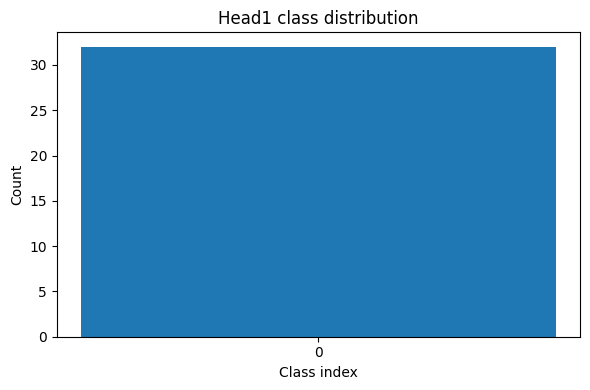

Saved: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/head1_distribution.png


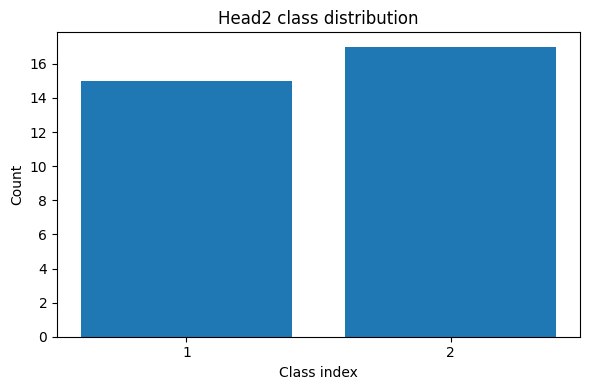

Saved: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/head2_distribution.png


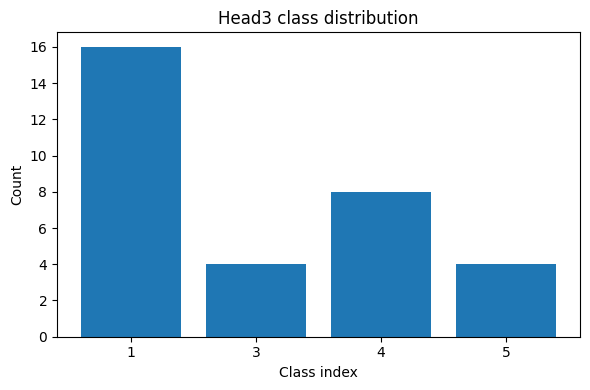

Saved: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/head3_distribution.png


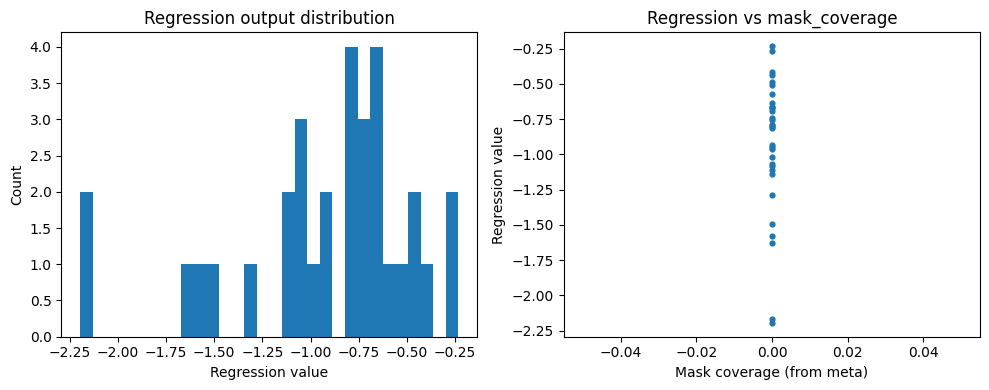

Saved: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/regression_plots.png
Skipping confusion for Head1 — missing columns.
Skipping confusion for Head2 — missing columns.
Skipping confusion for Head3 — missing columns.


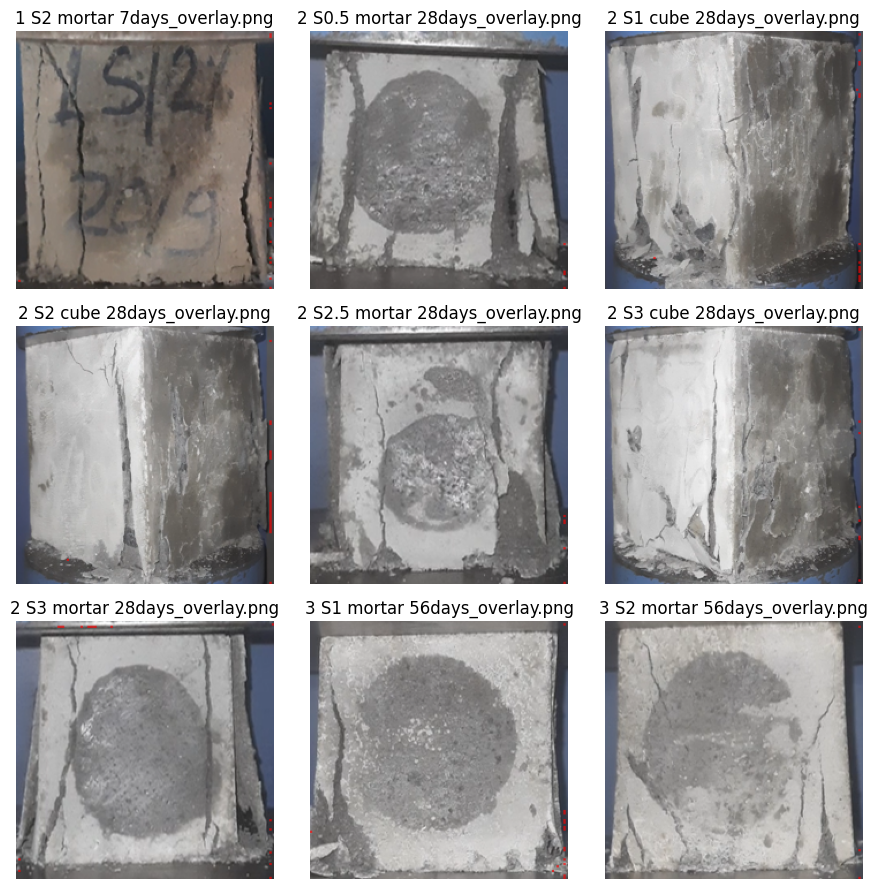

Saved: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/overlay_gallery.png
Wrote summary text: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations/summary_stats.txt
All visualizations saved to: /content/drive/MyDrive/Crack Study/predictions_batch/visualizations


,image_path,mask_prob_npy,mask_png,overlay_png,head1_argmax,head1_conf,head2_argmax,head2_conf,head3_argmax,head3_conf,head4_raw,regression,iou,dice
0,/content/crack_study_download/1 S2 mortar 7day...,1 S2 mortar 7days_mask_prob.npy,1 S2 mortar 7days_mask.png,1 S2 mortar 7days_overlay.png,0,0.965022,2,0.540281,1,0.575101,"[np.float64(0.0361), np.float64(0.5751), np.fl...",-1.139788,NaN,NaN
1,/content/crack_study_download/2 S0.5 mortar 28...,2 S0.5 mortar 28days_mask_prob.npy,2 S0.5 mortar 28days_mask.png,2 S0.5 mortar 28days_overlay.png,0,0.844514,1,0.571629,5,0.303587,"[np.float64(0.0801), np.float64(0.2746), np.fl...",-0.490069,NaN,NaN
2,/content/crack_study_download/2 S1 cube 28days...,2 S1 cube 28days_mask_prob.npy,2 S1 cube 28days_mask.png,2 S1 cube 28days_overlay.png,0,0.942021,1,0.770629,4,0.406033,"[np.float64(0.0409), np.float64(0.162), np.flo...",-0.233096,NaN,NaN
3,/content/crack_study_download/2 S2 cube 28days...,2 S2 cube 28days_mask_prob.npy,2 S2 cube 28days_mask.png,2 S2 cube 28days_overlay.png,0,0.951380,1,0.602536,3,0.268348,"[np.float64(0.0771), np.float64(0.1696), np.fl...",-0.507088,NaN,NaN
4,/content/crack_study_download/2 S2.5 mortar 28...,2 S2.5 mortar 28days_mask_prob.npy,2 S2.5 mortar 28days_mask.png,2 S2.5 mortar 28days_overlay.png,0,0.964841,2,0.511867,4,0.317153,"[np.float64(0.0156), np.float64(0.2999), np.fl...",-0.693137,NaN,NaN


In [ ]:
# ---------------- Graph visualization cell ----------------
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

# --- CONFIG ---
DRIVE_CSV = "/content/drive/MyDrive/Crack Study/predictions_batch/batch_predictions.csv"
PRED_DIR = "/content/crack_study_download/predictions_batch"
OUT_DIR = "/content/drive/MyDrive/Crack Study/predictions_batch/visualizations"
os.makedirs(OUT_DIR, exist_ok=True)
THUMB_N = 9   # number of overlay thumbnails to show (grid)

# --- load CSV ---
if not os.path.exists(DRIVE_CSV):
    raise FileNotFoundError("CSV not found at: " + DRIVE_CSV)
df = pd.read_csv(DRIVE_CSV)
print("Rows in CSV:", len(df))

# --- attempt to reconstruct metadata (mask_coverage) using build_meta_vector if available ---
def get_mask_coverage_from_meta(img_path):
    try:
        if 'build_meta_vector' in globals():
            meta = build_meta_vector(img_path, None)   # shape (1,13)
            return float(meta[0,5])
    except Exception:
        pass
    # fallback: try to infer from name (if you encoded coverage in csv, skip)
    return np.nan

df['mask_coverage'] = df['image_path'].apply(get_mask_coverage_from_meta)

# --- convert iou/dice/regression to numeric if present ---
for col in ['iou','dice','regression']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Plot 1: IoU / Dice histograms (if available) ---
plt.figure(figsize=(10,4))
plots_made = 0
if 'iou' in df.columns and df['iou'].notnull().any():
    plt.subplot(1,2,1)
    plt.hist(df['iou'].dropna(), bins=20)
    plt.title('IoU distribution')
    plt.xlabel('IoU')
    plt.ylabel('Count')
    plots_made += 1
if 'dice' in df.columns and df['dice'].notnull().any():
    plt.subplot(1,2,2)
    plt.hist(df['dice'].dropna(), bins=20)
    plt.title('Dice distribution')
    plt.xlabel('Dice')
    plt.ylabel('Count')
    plots_made += 1
if plots_made:
    fpath = os.path.join(OUT_DIR, "iou_dice_histograms.png")
    plt.tight_layout()
    plt.savefig(fpath, dpi=150)
    print("Saved:", fpath)
    plt.show()
else:
    print("No IoU/Dice data found in CSV to plot.")

# --- Plot 2: Classification head distributions (head1/head2/head3) ---
def plot_head_distribution(colname, title, outname):
    if colname not in df.columns:
        print("Skipping", colname, "- not in CSV")
        return
    vals = pd.to_numeric(df[colname], errors='coerce').dropna().astype(int)
    if vals.size == 0:
        print("No valid values for", colname)
        return
    counts = vals.value_counts().sort_index()
    plt.figure(figsize=(6,4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel("Class index")
    plt.ylabel("Count")
    path = os.path.join(OUT_DIR, outname)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()
    print("Saved:", path)

plot_head_distribution("head1_argmax", "Head1 class distribution", "head1_distribution.png")
plot_head_distribution("head2_argmax", "Head2 class distribution", "head2_distribution.png")
plot_head_distribution("head3_argmax", "Head3 class distribution", "head3_distribution.png")

# --- Plot 3: Regression distribution + regression vs mask_coverage scatter ---
if 'regression' in df.columns and df['regression'].notnull().any():
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df['regression'].dropna(), bins=30)
    plt.title("Regression output distribution")
    plt.xlabel("Regression value")
    plt.ylabel("Count")
    # scatter vs coverage
    plt.subplot(1,2,2)
    cov_ok = df['mask_coverage'].notnull() & df['regression'].notnull()
    if cov_ok.sum() > 0:
        plt.scatter(df.loc[cov_ok,'mask_coverage'], df.loc[cov_ok,'regression'], s=12)
        plt.xlabel("Mask coverage (from meta)")
        plt.ylabel("Regression value")
        plt.title("Regression vs mask_coverage")
    else:
        plt.text(0.5,0.5,"No mask_coverage data available", ha='center')
    fpath = os.path.join(OUT_DIR, "regression_plots.png")
    plt.tight_layout()
    plt.savefig(fpath, dpi=150)
    plt.show()
    print("Saved:", fpath)
else:
    print("No regression column found to plot.")

# --- Plot 4: Confusion matrix if ground-truth exists in CSV (gt_head1, gt_head2, gt_head3) ---
for i, (pred_col, gt_col, name) in enumerate([
    ("head1_argmax", "gt_head1", "Head1"),
    ("head2_argmax", "gt_head2", "Head2"),
    ("head3_argmax", "gt_head3", "Head3")
]):
    if pred_col in df.columns and gt_col in df.columns:
        # convert to ints
        true = pd.to_numeric(df[gt_col], errors='coerce').dropna().astype(int)
        pred = pd.to_numeric(df.loc[true.index, pred_col], errors='coerce').dropna().astype(int)
        if len(true)==0 or len(pred)==0:
            continue
        cm = confusion_matrix(true, pred, labels=sorted(list(set(true)|set(pred))))
        disp = ConfusionMatrixDisplay(cm, display_labels=sorted(list(set(true)|set(pred))))
        fig, ax = plt.subplots(figsize=(6,5))
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        plt.title(f"Confusion Matrix - {name}")
        p = os.path.join(OUT_DIR, f"confusion_{name}.png")
        plt.tight_layout()
        plt.savefig(p, dpi=150)
        plt.show()
        print("Saved:", p)
    else:
        print(f"Skipping confusion for {name} — missing columns.")

# --- Plot 5: thumbnails gallery of overlay images (first THUMB_N) ---
overlay_files = sorted(glob.glob(os.path.join(PRED_DIR, "*_overlay.png")))
if len(overlay_files) == 0:
    print("No overlay images found in:", PRED_DIR)
else:
    thumbs = overlay_files[:THUMB_N]
    ncols = int(np.ceil(np.sqrt(len(thumbs))))
    nrows = int(np.ceil(len(thumbs)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for ax in axes[len(thumbs):]:
        ax.axis('off')
    for i, f in enumerate(thumbs):
        img = np.array(Image.open(f).convert("RGB"))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(f))
    plt.tight_layout()
    p = os.path.join(OUT_DIR, "overlay_gallery.png")
    plt.savefig(p, dpi=150)
    plt.show()
    print("Saved:", p)

# --- Summary CSV stats saved as simple text ---
summary_txt = os.path.join(OUT_DIR, "summary_stats.txt")
with open(summary_txt, "w") as fh:
    fh.write(f"Total images: {len(df)}\n")
    if 'iou' in df.columns:
        fh.write(f"Mean IoU: {df['iou'].dropna().mean()}\n")
    if 'dice' in df.columns:
        fh.write(f"Mean Dice: {df['dice'].dropna().mean()}\n")
    for h in ["head1_argmax","head2_argmax","head3_argmax"]:
        if h in df.columns:
            fh.write(f"{h} value counts:\\n{df[h].value_counts().to_string()}\\n")
print("Wrote summary text:", summary_txt)

print("All visualizations saved to:", OUT_DIR)
display(pd.read_csv(DRIVE_CSV).head())

In [ ]:
import tensorflow as tf
import os

# Define the path to your saved model
MODEL_PATH = "/content/crack_study_download/models/final_multitask_model.h5"

# Load the model
try:
    loaded_model = tf.keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully!")
    loaded_model.summary()
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,383,696 (31.98 MB)

 Trainable params: 8,347,662 (31.84 MB)

 Non-trainable params: 36,032 (140.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# 1. install gdown (download from Google Drive by file id)
!pip install --quiet gdown

# 2. download the notebook to /content
!gdown --id 13mjdUo-a7hiJO_BZ_gHcs8wYJYtOi7oL -O /content/Crack-study-notebook.ipynb

# 3. list to confirm
!ls -lh /content/Crack-study-notebook.ipynb

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13mjdUo-a7hiJO_BZ_gHcs8wYJYtOi7oL
To: /content/Crack-study-notebook.ipynb
100% 2.33M/2.33M [00:00<00:00, 123MB/s]
-rw-r--r-- 1 root root 2.3M Dec  9 05:44 /content/Crack-study-notebook.ipynb


In [ ]:
!mkdir -p /content/Crack-study-ML-Model
!cp /content/Crack-study-notebook.ipynb /content/Crack-study-ML-Model/

In [ ]:
%cd /content/Crack-study-ML-Model

/content/Crack-study-ML-Model


In [ ]:
!ls -lh


total 2.3M
-rw-r--r-- 1 root root 2.3M Dec  9 05:55 Crack-study-notebook.ipynb


In [ ]:
!git init
!git config user.email "gautamiprasas17@gmail.com"
!git config user.name "Gautami60"


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/Crack-study-ML-Model/.git/


In [ ]:
!git remote add origin https://github.com/Gautami60/Crack-study-ML-Model.git


In [ ]:
!git add .
!git commit -m "Initial commit — Crack study ML notebook"


[master (root-commit) 8d25569] Initial commit — Crack study ML notebook
 1 file changed, 1 insertion(+)
 create mode 100644 Crack-study-notebook.ipynb


In [1]:
%cd /content/Crack-study-ML-Model
# search for token-like strings
!grep -R --line-number "ghp_" . || echo "No ghp_ token strings found."

[Errno 2] No such file or directory: '/content/Crack-study-ML-Model'
/content
No ghp_ token strings found.


In [2]:
# run this in a Python cell
import os, io, json, re

root = "/content/Crack-study-ML-Model"
pattern = re.compile(r"ghp_[A-Za-z0-9_]+")
changed_files = []

for subdir, _, files in os.walk(root):
    for name in files:
        path = os.path.join(subdir, name)
        try:
            if name.endswith(".ipynb"):
                with open(path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                text = json.dumps(data)
                if pattern.search(text):
                    text = pattern.sub("***REDACTED***", text)
                    with open(path, "w", encoding="utf-8") as f:
                        f.write(text)
                    changed_files.append(path)
            elif name.endswith((".py", ".md", ".txt", ".json")):
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    txt = f.read()
                if pattern.search(txt):
                    txt = pattern.sub("***REDACTED***", txt)
                    with open(path, "w", encoding="utf-8") as f:
                        f.write(txt)
                    changed_files.append(path)
        except Exception as e:
            print("Skipped", path, "due to", e)

print("Sanitized files:")
for p in changed_files:
    print(" -", p)

if not changed_files:
    print("No files needed sanitization.")


Sanitized files:
No files needed sanitization.


In [3]:
%cd /content/Crack-study-ML-Model
!git add .
!git commit -m "Cleanup: remove leaked token and initial commit" || echo "Nothing to commit or commit failed"


[Errno 2] No such file or directory: '/content/Crack-study-ML-Model'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
Nothing to commit or commit failed


In [5]:
!ls -lah /content


total 16K
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 .
drwxr-xr-x 1 root root 4.0K Dec 10 06:29 ..
drwxr-xr-x 4 root root 4.0K Nov 20 14:30 .config
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [6]:
!mkdir -p /content/Crack-study-ML-Model


In [9]:
!ls /content


Crack-study-ML-Model  sample_data


In [10]:
!find / -type f -name "*.ipynb" 2>/dev/null


/usr/local/lib/python3.12/dist-packages/nbclassic/bundler/tests/resources/empty.ipynb
/usr/local/lib/python3.12/dist-packages/notebook/bundler/tests/resources/empty.ipynb
/usr/local/lib/python3.12/dist-packages/panel/tests/ui/io/app.ipynb
/usr/local/lib/python3.12/dist-packages/spreg/optional_imports.ipynb
/usr/local/lib/python3.12/dist-packages/wasabi/tests/test-data/wasabi-test-notebook.ipynb
/usr/local/lib/python3.12/dist-packages/libpysal/cg/tests/fast_point_in_polygon_algorithm.ipynb
/usr/local/lib/python3.12/dist-packages/flax/core/flax_functional_engine.ipynb
/usr/local/lib/python3.12/dist-packages/holoviews/examples/reference/containers/plotly/Layout.ipynb
/usr/local/lib/python3.12/dist-packages/holoviews/examples/reference/containers/plotly/NdLayout.ipynb
/usr/local/lib/python3.12/dist-packages/holoviews/examples/reference/containers/plotly/NdOverlay.ipynb
/usr/local/lib/python3.12/dist-packages/holoviews/examples/reference/containers/plotly/Overlay.ipynb
/usr/local/lib/python